In [1]:
state = 'ME' 
year = 2020
obj_type = 'inverse_Polsby_Popper'
starting_deviation = 0.01

In [2]:
import sys, os
src_path = os.path.abspath(os.path.join('..', '..', 'src'))
sys.path.append(src_path)

In [3]:
filepath = '../../dat/' + str(year) + '/'
filename = state + '_county.json'
filename2 = state + '_county.shp'

In [4]:
from read import read_graph_from_json

G = read_graph_from_json(state, filepath + filename, year=year)
print(f"The state of {state} has {G._k} districts.")
G._ideal_population = sum(G.nodes[i]['TOTPOP'] for i in G.nodes) / G._k

The state of ME has 2 districts.


In [5]:
#import warm starts
sys.path.append(os.path.abspath('../heuristic'))

from ME_plans_2020 import plans
print(f"Loaded {len(plans)} plans from file.")
warm_starts = plans

Loaded 18 plans from file.


In [6]:
from pareto import filter_and_sort_pareto
from metrics import scores

plans_scores = [scores(G, plan, G._ideal_population, obj_type) for plan in warm_starts]
_,_,nondominated_warm_starts_plans = filter_and_sort_pareto(plans=warm_starts, upper_bounds=plans_scores, obj_type=obj_type)
print(f"Selected {len(nondominated_warm_starts_plans)} nondominated warm start plans")

Selected 3 nondominated warm start plans


In [7]:
from epsilon_constraint import epsilon_constraint_method

(plans, obj_bounds, deviations) = epsilon_constraint_method(
            G,                 
            obj_type,          
            contiguity = 'lcut',                                             # {'lcut', 'scf', 'shir'} 
            cutoff=None,       
            verbose= True,
            warm_start_mode = 'user',                                        # {'None', 'user', 'refinement'}
            warm_starts=warm_starts,                                         # if you have user define warm starts else it is None
            starting_deviation=starting_deviation, 
            time_limit=7200, 
            sizes=None,      
            max_B=True,                                                      # If symmetry_breaking is 'orbitope' or you have warm_start, max_B should be True   
            symmetry_breaking='orbitope',                                    # {None, 'orbitope', 'rsum'} 
            state=state,
            year=year
        )

Initially, L = 674368 and U = 687991 and k = 2.

****************************************
Trying deviation = 6811.795
****************************************
Using user-provided warm starts.
Selected warm_start = [[0, 3, 6, 12], [1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15]]
Objective value: 3.094050204160066
Deviation: 2777.5

****************************************
Running labeling model!
****************************************
L = 674368 and U = 687991
Set parameter Username
Set parameter LicenseID to value 2608266
Academic license - for non-commercial use only - expires 2026-01-09
sizes =  [1, 1]
Solving the max B problem (as MIP) for use in the vertex ordering...
Set parameter LogToConsole to value 0
Set parameter LazyConstraints to value 1
Applying warm start!
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0

Set parameter LazyConstraints to value 1
Applying warm start!
Set parameter MIPGap to value 0
Set parameter FeasibilityTol to value 1e-07
Set parameter TimeLimit to value 7200
Set parameter IntFeasTol to value 1e-07
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Xeon(R) CPU E5-2630 v4 @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
TimeLimit  7200
FeasibilityTol  1e-07
IntFeasTol  1e-07
MIPGap  0
LazyConstraints  1

Optimize a model with 456 rows, 370 columns and 1517 nonzeros
Model fingerprint: 0xf68d31bb
Model has 2 quadratic constraints
Variable types: 102 continuous, 268 integer (268 binary)
Coefficient statistics:
  Matrix range     [8e-02, 3e+05]
  QMatrix range    [1e+00, 1e+01]
  Objective range  [5e-01, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 7e+05]

User MIP start produced solution with objective

Best objective -, best bound -, gap -

User-callback calls 2203, time in user-callback 0.04 sec
No feasible solution found.

****************************************
No feasible solution found! Gurobi status: 3
****************************************


In [8]:
result = list(zip(plans, obj_bounds , deviations))

In [9]:
epsilon = 1 / (2 * G._k)
min_deviation = min(round(r[2], 1) for r in result)

if min_deviation < epsilon:
    no_solution_region = None
else:
    no_solution_region = [0, min_deviation]

if no_solution_region is not None:
    print(f"No feasible solution was found within the region: {no_solution_region}")

No feasible solution was found within the region: [0, 750.5]



####################################################################################################
Pareto Frontier for state ME,  objective inverse_Polsby_Popper
####################################################################################################

Pareto front plans: [[[5, 6, 7, 8, 10, 12, 13, 14], [0, 1, 2, 3, 4, 9, 11, 15]], [[1, 2, 3, 4, 9, 10, 11, 12, 14, 15], [0, 5, 6, 7, 8, 13]], [[0, 3, 6, 12], [1, 2, 4, 5, 7, 8, 9, 10, 11, 13, 14, 15]]]
Pareto front upper bounds: [[750.5, 6.126891015162613], [1882.5, 5.047485703140484], [2777.5, 3.094050204160066]]
Pareto front lower bounds: [[750.5, 6.126891015162613], [1882.5, 5.047485703140484], [2777.5, 3.094050204160066]]


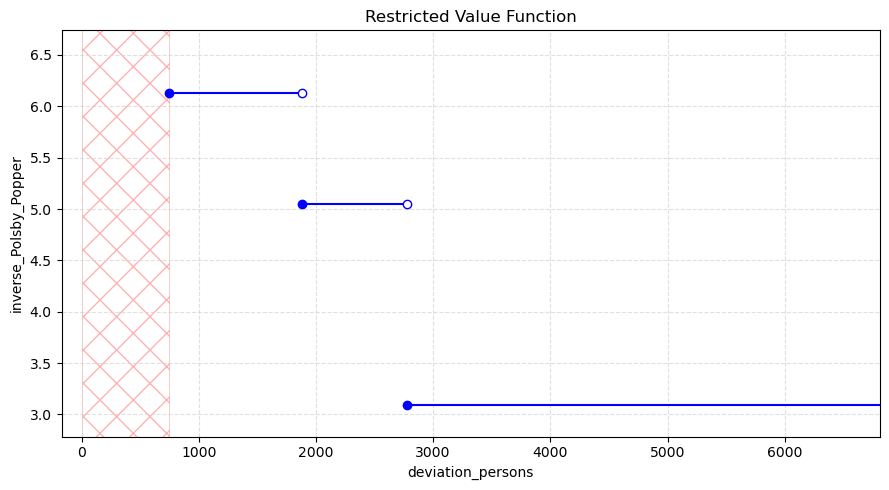

In [10]:
from pareto import plot_pareto_frontiers

plot_pareto_frontiers(
                G,
                method='epsilon_constraint_method',
                plans=None,                                   #if method ='epsilon_constraint_method' is None 
                obj_types=obj_type,                               
                ideal_population=G._ideal_population,
                state=state,
                filepath=filepath,
                filename2=filename2,
                no_solution_region=no_solution_region,
                year=year,
                result=result                               #if method ='heuristic' is None 
             )


####################################################################################################
Pareto maps for state ME, objective inverse_Polsby_Popper
####################################################################################################



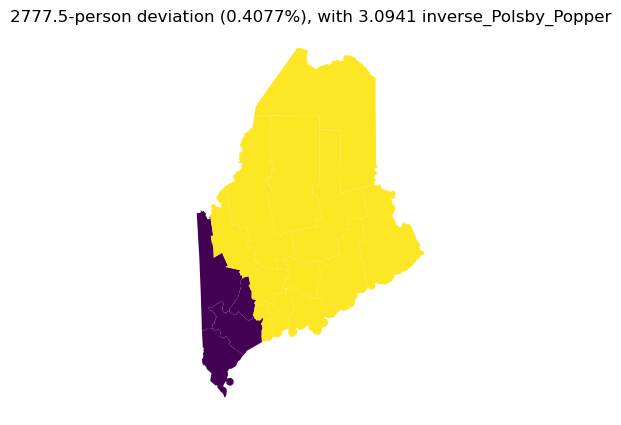

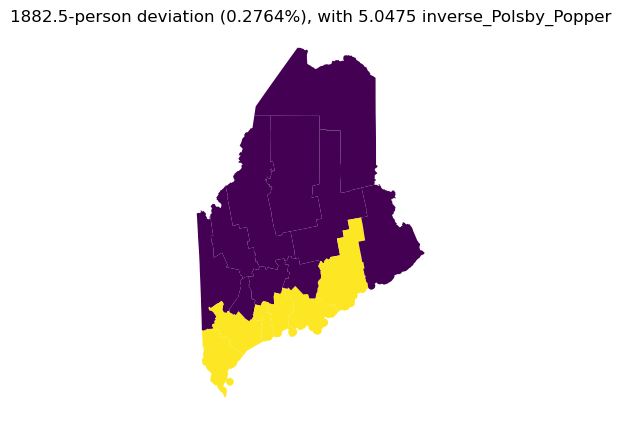

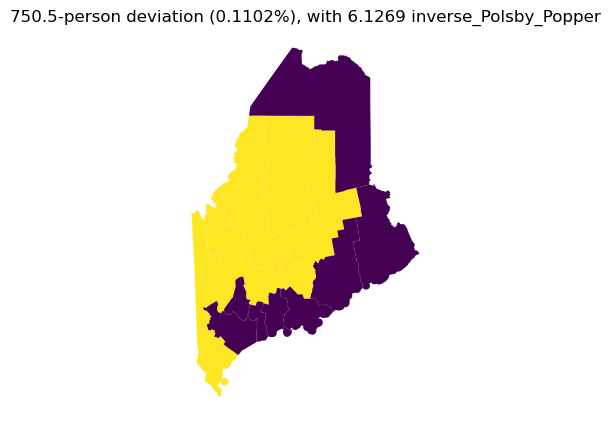

In [11]:
from draw import draw_plan
from metrics import observed_deviation_persons, compute_obj

print(f"\n{'#' * 100}\nPareto maps for state {state}, objective {obj_type}\n{'#' * 100}\n")

format_obj = {
    'bottleneck_Polsby_Popper': lambda x: round(1 /x, 4),
    'cut_edges': lambda x: int(x)}
G._L = 0
G._U = G._k * G._ideal_population

for plan, obj_bound, dev in result:
    obs_dev = observed_deviation_persons(G, plan, G._ideal_population)
    obj = compute_obj(G, plan, obj_type)
    obj_val = format_obj.get(obj_type, lambda x: round(x, 4))(obj)
    deviation_percentage = round(100 * dev / G._ideal_population, 4)
    title = f"{round(obs_dev, 2)}-person deviation ({deviation_percentage}%), with {obj_val} {obj_type}"
    draw_plan(filepath, filename2, G, plan, title=title, year=year)